In [445]:
import sklearn
import skimage
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_digits
from sklearn.decomposition import IncrementalPCA
from PIL import Image
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.measure import block_reduce

import glob

In [10]:
def get_tile_x(image_number): #Gets the horizontal position of the tile (0 on the left)
    return np.mod(image_number,horizontal_number)

In [11]:
def get_tile_y(image_number): #Gets the vertical position of the tile (0 at the top)
    return np.floor_divide(image_number,horizontal_number)

In [82]:
def get_tile_point(image_number): #Gets the horizontal and vertical positions of the tile as a tuple of the form (hori, vert), 0,0 in top left
    return (np.mod(image_number,horizontal_number),np.floor_divide(image_number,horizontal_number))


In [92]:
def get_tile_number(tile_point): #Gets the number of a tile from its point in the grid
    return(tile_point[0]+horizontal_number*tile_point[1])


In [624]:
def check_brightness_position(image_number,point,size, bright): #Plots a square on the image so that it is possible to see exactly where is being searched
    image = ims_brightened[image_number]
    colors = [0, 0.8]
    color = bright #0 marks a dark square, 1 marks a bright square
    x = point[0]
    y = point[1]
    image[y+size, (x-size):(x+size)] = 0.8
    image[y-size, (x-size):(x+size)] = 0.8 
    image[(y-size):(y+size), x+size] = 0.8
    image[(y-size):(y+size), x-size] = 0.8
    print("Image number: ", image_number, " Comparison location:", point, " Size: ", size, " Square drawn")
    #return np.median(brightness_array)

In [507]:
def get_brightness(image_number,point,size): #Gets the mean brightness of a square extending size units out in each direction 
    image = ims_brightened[image_number] #This takes the point in the form x-y, this is a mistake but is also fine
    x = point[0]
    y = point[1]
    brightness_array = []
    for i in range((2*size)+1):
        for j in range((2*size)+1):
            brightness_array.append(image[y-size+i][x-size+j])
            #print(y-size+i, x-size+j, image[y-size+i][x-size+j])
    print("Image number: ", image_number, " Comparison location:", point, " Size: ", size, " Brightness: ", np.mean(brightness_array))
            
    return np.mean(brightness_array)
    #return np.median(brightness_array)

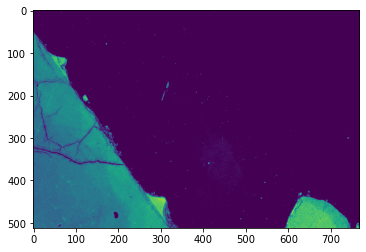

In [610]:
plt.imshow(ims_brightened[8]*65535)

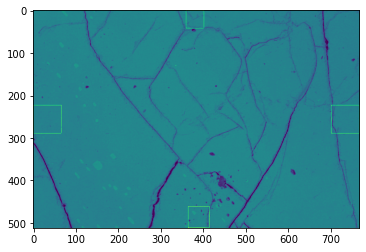

In [623]:
plt.imshow(ims_brightened[17])

In [602]:
check_get_brightness_position(get_tile_point(1), get_tile_point(0))

Image number:  1  Comparison location: (34, 306)  Size:  34  Square drawn
Image number:  0  Comparison location: (733, 206)  Size:  34  Square drawn


In [530]:
733+33+1

767

In [533]:
ims[0][256, 767]

0.039215688

In [ ]:
#This space exists to avoid scrolling

In [625]:
def check_get_brightness_position(image_1_point, image_2_point): #Replica of the point selection logic but instead marks the points
    
    tile_1_x = image_1_point[0] #Legacy from the version of this function which used image numbers
    tile_1_y = image_1_point[1]
    tile_2_x = image_2_point[0]
    tile_2_y = image_2_point[1]
    image_1_number = get_tile_number(image_1_point)
    image_2_number = get_tile_number(image_2_point)
    #tile_1_x = get_tile_x(image_1_number) 
    #tile_1_y = get_tile_y(image_1_number)
    #tile_2_x = get_tile_x(image_2_number)
    #tile_2_y = get_tile_y(image_2_number)
    
    #Locations of the centres of the edges of any given tile
    right_edge = np.array((ims[0].shape[1]-1,ims[0].shape[0]/2))
    left_edge = np.array((0,ims[0].shape[0]/2))
    bottom_edge = np.array((ims[0].shape[1]/2,ims[0].shape[0]-1))
    top_edge = np.array((ims[0].shape[1]/2,0))
    
    #I apologise but this is going to be sign hell
    
    
    #Unless something very strange happens the limiting dimension of left-right comparison area sizes will be the width of the overlap area, and top-bottom sizes will be limited by the height
    overlap_area_width = horizontal_overlap + np.sign(tile_1_x-tile_2_x)*(horizontal_columnwise_tuning[tile_1_x] - horizontal_columnwise_tuning[tile_2_x])
    overlap_area_height = vertical_overlap + np.sign(tile_1_y-tile_2_y)*(vertical_rowwise_tuning[tile_1_y] - vertical_rowwise_tuning[tile_2_y])
    
    #Pre computing tuning values to keep them out of the if nest for clarity
    tuning_x = horizontal_columnwise_tuning[tile_1_x] - horizontal_columnwise_tuning[tile_2_x] + horizontal_rowwise_tuning[tile_1_y] - horizontal_rowwise_tuning[tile_2_y]
    tuning_y = vertical_columnwise_tuning[tile_1_x] - vertical_columnwise_tuning[tile_2_x] + vertical_rowwise_tuning[tile_1_y] - vertical_rowwise_tuning[tile_2_y]
    
    #tuning x and tuning y are the "leftness" and "upness" of the primary tile relative to the secondary
    #They should be ADDED to the primary edge-secondary edge vector because greater primary leftness means the vector needs to be more rightward
    #similarly greater primary upness means the primary edge-secondary edge vector needs a greater downward component
    #This vector flip is inherited from the tile positioning logic
    
    #When the tiles are placed directly next to eachother with edges aligned, this is the vector from primary edge point to secondary edge point
    nudge = np.array([(tile_2_x-tile_1_x), (tile_2_y-tile_1_y)])
    
    #Goal is to find the vector from the relevant edge of the primary tile to the relevant edge of the secondary tile
    #Find the midpoint of that vector
    #Find that point in both image coordinate systems
    
    if abs(tile_1_x-tile_2_x) == 1 and tile_1_y-tile_2_y == 0: #if tiles are left-right adjacent
        
        relative_y = tuning_y #the y component of the primary edge-secondary edge vector in stitched space
        relative_x = (np.sign(tile_1_x-tile_2_x)*overlap_area_width) + nudge[0] #the x component
        edge_edge_vector = np.array((relative_x, relative_y)) #Vector from the relevant edge of the primary tile to the relevant edge of the secondary tile in stitched space
        size_limit = int(np.floor((overlap_area_width-1)/2)) #if odd this needs to just be the floor of the half, but if even it needs to be 1 less than the floor of the half, this achieves that 
        if tile_1_x > tile_2_x: #tile 1 is on the right of tile 2
            
            tile_1_point = left_edge + np.floor(edge_edge_vector/2) #in a case where this vector is odd, these must be rounded to avoid looking for fractional pixels,
            tile_2_point = right_edge - np.ceil(edge_edge_vector/2) #without floor and ceil the target pixels would be next to eachother instead of on top
        
        if tile_1_x < tile_2_x: #tile 1 is on the left of tile 2
            
            tile_1_point = right_edge + np.floor(edge_edge_vector/2)
            tile_2_point = left_edge - np.ceil(edge_edge_vector/2)
            
    elif abs(tile_1_y-tile_2_y) == 1 and tile_1_x-tile_2_x == 0: #if tiles are top-bottom adjacent
        
        relative_x = tuning_x #the x component of the primary edge-secondary edge vector in stitched space
        relative_y = (np.sign(tile_1_y-tile_2_y)*overlap_area_height) + nudge[1] #the y component
        edge_edge_vector = np.array((relative_x, relative_y)) #Vector from the relevant edge of the primary tile to the relevant edge of the secondary tile in stitched space
        size_limit = int(np.floor((overlap_area_height-1)/2))
        if tile_1_y > tile_2_y: #tile 1 is below tile 2
            
            tile_1_point = top_edge + np.floor(edge_edge_vector/2) #in a case where this vector is odd, these must be rounded to avoid looking for fractional pixels,
            tile_2_point = bottom_edge - np.ceil(edge_edge_vector/2) #without floor and ceil the target pixels would be next to eachother instead of on top
        
        if tile_1_y < tile_2_y: #tile 1 is above tile 2
            
            tile_1_point = bottom_edge + np.floor(edge_edge_vector/2)
            tile_2_point = top_edge - np.ceil(edge_edge_vector/2)
            
    else:
        print("WARNING: images ", image_1_number, " and ", image_2_number, " sent to get_brightness_factor do not share an edge")
        return 1
    
    
   
    
    tile_1_point = tuple(map(int, tile_1_point)) #Convert the tuples of floats made above into tuples of integers
    tile_2_point = tuple(map(int, tile_2_point))
    
    
    check_brightness_position(image_1_number, tile_1_point, size_limit, 1)
    check_brightness_position(image_2_number, tile_2_point, size_limit, 0)
    

In [448]:
def get_brightness_factor(image_1_point, image_2_point): #Gets the factor by which image 2's brightnesses must be scaled to match image 1
    
    
    tile_1_x = image_1_point[0] #Legacy from the version of this function which used image numbers
    tile_1_y = image_1_point[1]
    tile_2_x = image_2_point[0]
    tile_2_y = image_2_point[1]
    image_1_number = get_tile_number(image_1_point)
    image_2_number = get_tile_number(image_2_point)
    #tile_1_x = get_tile_x(image_1_number) 
    #tile_1_y = get_tile_y(image_1_number)
    #tile_2_x = get_tile_x(image_2_number)
    #tile_2_y = get_tile_y(image_2_number)
    
    #Locations of the centres of the edges of any given tile
    right_edge = np.array((ims[0].shape[1]-1,ims[0].shape[0]/2))
    left_edge = np.array((0,ims[0].shape[0]/2))
    bottom_edge = np.array((ims[0].shape[1]/2,ims[0].shape[0]-1))
    top_edge = np.array((ims[0].shape[1]/2,0))
    
    #I apologise but this is going to be sign hell
    
    
    #Unless something very strange happens the limiting dimension of left-right comparison area sizes will be the width of the overlap area, and top-bottom sizes will be limited by the height
    overlap_area_width = horizontal_overlap + np.sign(tile_1_x-tile_2_x)*(horizontal_columnwise_tuning[tile_1_x] - horizontal_columnwise_tuning[tile_2_x])
    overlap_area_height = vertical_overlap + np.sign(tile_1_y-tile_2_y)*(vertical_rowwise_tuning[tile_1_y] - vertical_rowwise_tuning[tile_2_y])
    
    #Pre computing tuning values to keep them out of the if nest for clarity
    tuning_x = horizontal_columnwise_tuning[tile_1_x] - horizontal_columnwise_tuning[tile_2_x] + horizontal_rowwise_tuning[tile_1_y] - horizontal_rowwise_tuning[tile_2_y]
    tuning_y = vertical_columnwise_tuning[tile_1_x] - vertical_columnwise_tuning[tile_2_x] + vertical_rowwise_tuning[tile_1_y] - vertical_rowwise_tuning[tile_2_y]
    
    #tuning x and tuning y are the "leftness" and "upness" of the primary tile relative to the secondary
    #They should be ADDED to the primary edge-secondary edge vector because greater primary leftness means the vector needs to be more rightward
    #similarly greater primary upness means the primary edge-secondary edge vector needs a greater downward component
    #This vector flip is inherited from the tile positioning logic
    
    #When the tiles are placed directly next to eachother with edges aligned, this is the vector from primary edge point to secondary edge point
    nudge = np.array([(tile_2_x-tile_1_x), (tile_2_y-tile_1_y)])
    
    #Goal is to find the vector from the relevant edge of the primary tile to the relevant edge of the secondary tile
    #Find the midpoint of that vector
    #Find that point in both image coordinate systems
    
    if abs(tile_1_x-tile_2_x) == 1 and tile_1_y-tile_2_y == 0: #if tiles are left-right adjacent
        
        relative_y = tuning_y #the y component of the primary edge-secondary edge vector in stitched space
        relative_x = (np.sign(tile_1_x-tile_2_x)*overlap_area_width) + nudge[0] #the x component
        edge_edge_vector = np.array((relative_x, relative_y)) #Vector from the relevant edge of the primary tile to the relevant edge of the secondary tile in stitched space
        size_limit = int(np.floor((overlap_area_width-1)/2)) #if odd this needs to just be the floor of the half, but if even it needs to be 1 less than the floor of the half, this achieves that 
        if tile_1_x > tile_2_x: #tile 1 is on the right of tile 2
            
            tile_1_point = left_edge + np.floor(edge_edge_vector/2) #in a case where this vector is odd, these must be rounded to avoid looking for fractional pixels,
            tile_2_point = right_edge - np.ceil(edge_edge_vector/2) #without floor and ceil the target pixels would be next to eachother instead of on top
        
        if tile_1_x < tile_2_x: #tile 1 is on the left of tile 2
            
            tile_1_point = right_edge + np.floor(edge_edge_vector/2)
            tile_2_point = left_edge - np.ceil(edge_edge_vector/2)
            
    elif abs(tile_1_y-tile_2_y) == 1 and tile_1_x-tile_2_x == 0: #if tiles are top-bottom adjacent
        
        relative_x = tuning_x #the x component of the primary edge-secondary edge vector in stitched space
        relative_y = (np.sign(tile_1_y-tile_2_y)*overlap_area_height) + nudge[1] #the y component
        edge_edge_vector = np.array((relative_x, relative_y)) #Vector from the relevant edge of the primary tile to the relevant edge of the secondary tile in stitched space
        size_limit = int(np.floor((overlap_area_height-1)/2))
        if tile_1_y > tile_2_y: #tile 1 is below tile 2
            
            tile_1_point = top_edge + np.floor(edge_edge_vector/2) #in a case where this vector is odd, these must be rounded to avoid looking for fractional pixels,
            tile_2_point = bottom_edge - np.ceil(edge_edge_vector/2) #without floor and ceil the target pixels would be next to eachother instead of on top
        
        if tile_1_y < tile_2_y: #tile 1 is above tile 2
            
            tile_1_point = bottom_edge + np.floor(edge_edge_vector/2)
            tile_2_point = top_edge - np.ceil(edge_edge_vector/2)
            
    else:
        print("WARNING: images ", image_1_number, " and ", image_2_number, " sent to get_brightness_factor do not share an edge")
        return 1
    
    
    '''
    right_edge = np.array((ims[0].shape[1]-(horizontal_overlap/2),ims[0].shape[0]/2))
    left_edge = np.array((horizontal_overlap/2,ims[0].shape[0]/2))
    bottom_edge = np.array((ims[0].shape[1]/2,ims[0].shape[0]-(vertical_overlap/2)))
    top_edge = np.array((ims[0].shape[1]/2,vertical_overlap/2))
    if abs(tile_1_x-tile_2_x) == 1 and tile_1_y-tile_2_y == 0: #if tiles are left-right adjacent
        offset_tuple = np.array((horizontal_columnwise_tuning[tile_1_x]-horizontal_columnwise_tuning[tile_2_x],vertical_columnwise_tuning[tile_1_x]-vertical_columnwise_tuning[tile_2_x]))
            #Since the overlap between tiles isn't perfectly consistent, we need to find the point in image 2 which corresponds exactly to the relevant point in image 1
        if tile_1_x > tile_2_x: #tile 1 is on the right of tile 2
            tile_1_point = left_edge
            tile_2_point = right_edge + offset_tuple
        if tile_1_x < tile_2_x: #tile 1 is on the left of tile 2
            tile_1_point = right_edge
            tile_2_point = left_edge + offset_tuple
            
    elif tile_1_x-tile_2_x == 0 and abs(tile_1_y-tile_2_y) == 1: #if tiles are top-bottom adjacent
        offset_tuple = np.array((horizontal_rowwise_tuning[tile_1_y]-horizontal_rowwise_tuning[tile_2_y],vertical_rowwise_tuning[tile_1_y]-vertical_rowwise_tuning[tile_2_y]))
            #Since the overlap between tiles isn't perfectly consistent, we need to find the point in image 2 which corresponds exactly to the relevant point in image 1
        if tile_1_y > tile_2_y: #tile 1 is beneath tile 2
            tile_1_point = top_edge
            tile_2_point = bottom_edge + offset_tuple
        if tile_1_y < tile_2_y: #tile 1 is above tile 2
            tile_1_point = bottom_edge
            tile_2_point = top_edge + offset_tuple
            
    else:
        print("WARNING: images ", image_1_number, " and ", image_2_number, " sent to get_brightness_factor do not share an edge")
        return 1
    
    x_size_limit = (horizontal_overlap/2) + offset_tuple[0] 
    y_size_limit = (vertical_overlap/2) + offset_tuple[1] 
    size_limit = int(np.min((x_size_limit, y_size_limit))-1)
    '''
    #return(size_limit)
    
    tile_1_point = tuple(map(int, tile_1_point)) #Convert the tuples of floats made above into tuples of integers
    tile_2_point = tuple(map(int, tile_2_point))
    
    
    tile_1_brightness = get_brightness(image_1_number, tile_1_point, size_limit)
    tile_2_brightness = get_brightness(image_2_number, tile_2_point, size_limit)
    
    return tile_2_brightness/tile_1_brightness
    
    
    
            

In [517]:
#ims_brightened[14].shape

In [516]:
#get_tile_point(13)

In [515]:
#get_brightness_factor(get_tile_point(188), get_tile_point(199))

In [611]:
def do_tile(image_point, done_tracker): #Calibrates the brightness of a given tile
    working_ratios = []
    adjustment_list = np.array([np.array([0, -1]), np.array([1, 0]), np.array([0, 1]), np.array([-1, 0])]) 
    
    for i in range(4):
        neighbour_in_question_point = image_point+adjustment_list[i] #consider a neighbour
        if neighbour_in_question_point[0] < horizontal_number and neighbour_in_question_point[0] >=0 and neighbour_in_question_point[1] <vertical_number and neighbour_in_question_point[1] >= 0:  
            if done_tracker[neighbour_in_question_point[0], neighbour_in_question_point[1]] == 1: #if it has been done
                working_ratios.append(get_brightness_factor(neighbour_in_question_point, image_point)) #list the factor between the tile and neighbour
                check_get_brightness_position(neighbour_in_question_point, image_point) #debugging tool which marks where the brightness factor finder is looking
    if len(working_ratios)>=1: 
        overall_ratio = np.median(working_ratios) 
        print(overall_ratio)
    else:
        overall_ratio = 1
        print("BADBADBADBAD")
        
    #take median, this is simple but might work fairly nicely, the nuclear option would be to least squares fit, which in the case of 1 or 2 neighbours (most common) is identical, and this may help avoid outliers in 3 or 4-neighbour cases
    ims_brightened[get_tile_number(image_point)] = ims[get_tile_number(image_point)]*overall_ratio
    
    done_tracker[image_point[0]][ image_point[1]] += 1 #Mark tile as done
    brightness_tracker[image_point[0]][ image_point[1]] += overall_ratio #debugging tool
    
    
    return done_tracker

In [456]:
def find_done_neighbour_numbers(done_tracker):
    #Yes I'm iterating over the whole thing instead of being selective what of it
    neighbour_tracker = np.zeros((horizontal_number, vertical_number))
    for i in range(horizontal_number):
        for j in range(vertical_number):
            if done_tracker[i][j] == 1:
                #print(i," ",j)
                neighbours = np.array([np.array([i, j-1]), np.array([i+1, j]), np.array([i, j+1]), np.array([i-1, j])]) 
                for k in range(4):
                    if neighbours[k][0] < horizontal_number and neighbours[k][0] >=0 and neighbours[k][1] <vertical_number and neighbours[k][1] >= 0:
                        #print(neighbours[k])
                        neighbour_tracker[neighbours[k][0], neighbours[k][1]] +=1
    #clean up, since done tiles might otherwise be the tiles with the most neighbours
    for i in range(horizontal_number):
        for j in range(vertical_number):
            if done_tracker[i][j] != 0:
                neighbour_tracker[i][j] = 0
    return neighbour_tracker
            
            
            

In [471]:
def propagate_brightness(start_tile_number):
    global ims_brightened
    ims_brightened = ims.copy()
    done_tracker = np.zeros((horizontal_number, vertical_number))
    done_tracker[get_tile_point(start_tile_number)] = 1
    global brightness_tracker
    brightness_tracker = np.zeros((horizontal_number, vertical_number))
    #for i in range(10):
    while np.min(done_tracker) == 0:
        neighbour_array = find_done_neighbour_numbers(done_tracker)
        #print(neighbour_array)
        #tile_with_most_neighbours = np.unravel_index(neighbour_array.argmax(), neighbour_array.shape)
        #print(tile_with_most_neighbours)
        #find list of indices of tiles with highest number of neighbours, instead of just the first instance which produces a top-left bias
        options = np.argwhere((neighbour_array == np.max(neighbour_array)))
        #print(options)
        selected = np.array(options[np.random.randint(0, options.shape[0])])
        #print(selected)
        done_tracker = do_tile(selected, done_tracker)
        print(done_tracker)
    
#    primary_x = get_tile_x(start_tile)
#    primary_y = get_tile_y(start_tile)
#    side_codes = np.array(["Top", "Right", "Bottom", "Left"])
#    #top-right-bottom-left
#    edge_buds = np.array([np.array([primary_x, primary_y-1]), np.array([primary_x+1, primary_y]), np.array([primary_x, primary_y+1]), np.array([primary_x-1, primary_y])]) 
#    #progress
#    print(edge_buds)
#    for i in range(4): #build the initial edges
#        build_new_edge(edge_buds[i], side_codes[i])
#        
#    build_corners(edge_buds) #build the corners
    
   
    
    
    #print(done_tracker)

In [631]:
propagate_brightness(17)

Image number:  17  Comparison location: (389, 486)  Size:  25  Brightness:  0.46687782
Image number:  28  Comparison location: (378, 25)  Size:  25  Brightness:  0.4600137
Image number:  17  Comparison location: (389, 486)  Size:  25  Square drawn
Image number:  28  Comparison location: (378, 25)  Size:  25  Square drawn
0.9852978
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 1. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Image number:  17  Comparison location: (33, 256)  Size:  33  Brightness:  0.46268722
Image number:  16  Comparison location: (733, 256)  Size:  33  Brightness:  0.46385336
Image number:  17  Comparison location: (33, 256)  Size:  33  Square drawn
Image number:  16  Comparison location: (733, 256)  Size:  33  Square drawn
1.0025203
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 1. 0.]
 [0. 1. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Image number:  16  Comparison location: (389, 486)  Size:  25  Brig

Image number:  17  Comparison location: (733, 256)  Size:  33  Brightness:  0.44521052
Image number:  18  Comparison location: (33, 256)  Size:  33  Brightness:  0.44437766
Image number:  17  Comparison location: (733, 256)  Size:  33  Square drawn
Image number:  18  Comparison location: (33, 256)  Size:  33  Square drawn
0.9901761
[[0. 0. 0.]
 [0. 0. 0.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Image number:  18  Comparison location: (389, 486)  Size:  25  Brightness:  0.4348695
Image number:  29  Comparison location: (378, 25)  Size:  25  Brightness:  0.43201
Image number:  18  Comparison location: (389, 486)  Size:  25  Square drawn
Image number:  29  Comparison location: (378, 25)  Size:  25  Square drawn
Image number:  28  Comparison location: (733, 256)  Size:  33  Brightness:  0.45852062
Image number:  29  Comparison location: (33, 256)  Size:  33  Brightness:  0.46303055
Image number:  28  Comparison location: 

[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 0.]]
Image number:  21  Comparison location: (389, 486)  Size:  25  Brightness:  0.04423381
Image number:  32  Comparison location: (378, 25)  Size:  25  Brightness:  0.03995283
Image number:  21  Comparison location: (389, 486)  Size:  25  Square drawn
Image number:  32  Comparison location: (378, 25)  Size:  25  Square drawn
Image number:  31  Comparison location: (733, 256)  Size:  33  Brightness:  0.3610776
Image number:  32  Comparison location: (33, 256)  Size:  33  Brightness:  0.3183052
Image number:  31  Comparison location: (733, 256)  Size:  33  Square drawn
Image number:  32  Comparison location: (33, 256)  Size:  33  Square drawn
0.89238083
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]


In [489]:
for i in range(brightness_tracker.shape[0]):
    print(brightness_tracker[i])

[0.83221895 1.08576941 1.02533853]
[1.19362307 1.05348492 0.89661068]
[0.99437904 0.98596829 1.16137028]
[1.01465201 0.98871541 1.00060368]
[0.9883855  1.00047672 0.9892242 ]
[1.00211692 1.00252032 1.00238597]
[0.99167782 0.         0.9852978 ]
[0.98082191 0.99812931 0.99767232]
[0.91824102 1.04429376 0.9908179 ]
[1.11895525 0.94400746 1.12787104]
[0.89875782 1.11339307 0.89246583]


In [629]:
for i in range(brightness_tracker.shape[0]):
    print(brightness_tracker[i])

[2.20540047 1.86063802 1.40293026]
[0.87818182 1.29527497 1.8625772 ]
[1.09991574 0.91689241 1.24144185]
[1.12668729 0.94953513 1.09044397]
[0.97651631 0.99754137 0.9533757 ]
[1.09899831 1.00229192 1.07607853]
[0.93077409 0.         0.93092334]
[1.15496814 1.00079238 1.10957456]
[0.83158457 0.74798608 1.10896778]
[1.61604369 1.15972281 1.08494568]
[1.48028278 2.12875056 0.60600698]


In [632]:
for i in range(brightness_tracker.shape[0]):
    print(brightness_tracker[i])

[0.92116249 0.96587658 1.07912648]
[1.21118891 1.04104388 0.90273923]
[0.97995758 0.99433506 1.16016912]
[0.99651873 0.99450219 0.99584758]
[1.01083946 0.99326944 0.99284875]
[0.99980378 1.00252032 1.00238597]
[1.00791276 0.         0.9852978 ]
[1.03995132 0.99017608 1.00163019]
[0.90547866 1.01617634 1.00649774]
[1.10994959 0.94590914 1.13392115]
[0.90604991 1.10777354 0.89238083]


In [630]:
ims = [plt.imread(path) for path in glob.glob("C:/Users/rwfbl/brightness matcher testing/*.png")]

In [478]:
ims_brightened[0]

array([[0.03263604, 0.03263604, 0.03263604, ..., 0.03263604, 0.03263604,
        0.03263604],
       [0.03263604, 0.03263604, 0.03263604, ..., 0.03263604, 0.03263604,
        0.04246495],
       [0.03263604, 0.03263604, 0.03263604, ..., 0.03263604, 0.03263604,
        0.05243354],
       ...,
       [0.03263604, 0.03263604, 0.03263604, ..., 0.03263604, 0.03263604,
        0.03263604],
       [0.03263604, 0.03263604, 0.03263604, ..., 0.03263604, 0.03263604,
        0.03263604],
       [0.03263604, 0.03263604, 0.03263604, ..., 0.03263604, 0.03263604,
        0.03263604]], dtype=float32)

In [446]:
from IPython.display import Audio
sound_file = 'C:/Users/rwfbl/Eldritch_Blast.wav'
#Audio(sound_file, autoplay=True)

In [29]:
type(ims[0].shape[1])

int

In [27]:
#for i in range(300):
  #  print(ims[i].shape)

In [615]:
#For testing subset (rows 9-11 of john1)

horizontal_overlap = 68
vertical_overlap = 38
horizontal_number = 11
vertical_number = 3
horizontal_rowwise_tuning = [-13,-21,-32]
vertical_rowwise_tuning = [57,62,75]


horizontal_columnwise_tuning = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] #Greater means further to the left
vertical_columnwise_tuning = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] #Greater means higher

In [467]:
#For John1

#horizontal_overlap = 68
#vertical_overlap = 38
#horizontal_number = 11
#vertical_number = 19
#horizontal_rowwise_tuning = [0,12,20,18,18,13,5,0,-13,-21,-32,-40,-44,-44,-51,-59,-62,-65,-65] #Greater means further to the left
#vertical_rowwise_tuning = [0,0,0,14,14,29,35,40,57,62,75,84,88,99,102,113,120,124,134] #Greater means higher
#horizontal_columnwise_tuning = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] #Greater means further to the left
#vertical_columnwise_tuning = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] #Greater means higher

In [29]:
#For John2

#horizontal_overlap = 76
#vertical_overlap = 38
#horizontal_number = 21
#vertical_number = 19
#horizontal_rowwise_tuning = [0,14,18,15,7,6,1,-4,-17,-28,-40,-50,-56,-60,-61,-69,-72, -75, -78] #Greater means further to the left
#vertical_rowwise_tuning = [0,10,30,37,50,65,71,88,92,104,113,123,140,146,160,169, 180, 192, 199] #Greater means higher
#comment                       [1,   2,  3,  4,   5,   6,   7,   8,   9,   10,   11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21
#horizontal_columnwise_tuning = [0,   0,  -1, -1, -2,  -2,  -2,  -3,  -3,  -3,   -5,   -8,   -14,   -18, -22,  -24,  -27,  -28,  -31,   -31,   -34]
#vertical_columnwise_tuning =   [0,   0,  -1,  -1, -1,  -1,  -1,  -2,  -2,  -2,   -2,   -4,   -5,   -6,   -7,   -5,   -10,   -6,   -6,   -6,   -6]

In [30]:
#For John3

#horizontal_overlap = 68
#vertical_overlap = 48
#horizontal_number = 18
#vertical_number = 18
#horizontal_rowwise_tuning = [0,-3,-6, -8, -11, -13, -16, -19, -22, -25, -28, -31, -35, -38, -40, -43, -46, -48] #Greater means further to the left
#vertical_rowwise_tuning = [0,0,-6, -9, -13, -17, -18, -23, -22, -25, -27, -29, -36, -38, -43, -48, -49, -55] #Greater means higher
#comment                      [1,   2,   3,   4,   5,   6,   7,   8,   9,   10,   11,   12,   13,   14,   15,   16,   17,   18]
#horizontal_columnwise_tuning =[0,   -1,   -4,  -7, -10, -12,-12, -13,  -16,  -18, -21,  -23,  -29,  -32,  -36,  -38,   -38, -39]
#vertical_columnwise_tuning =  [0,   -3,   -4, -5,  -7,  -8,  -8,  -9,  -16,  -16,  -18,  -16,  -17,  -17, -16,   -17,   -17,   -19]    

In [617]:
guidelines = 0
horizontal_size = ims[0].shape[1]
vertical_size = ims[0].shape[0]
starting_row = 0
smallest_horizontal_offset = np.min((np.min(horizontal_rowwise_tuning), np.min(horizontal_columnwise_tuning)))
smallest_vertical_offset = np.min((np.min(vertical_rowwise_tuning), np.min(vertical_columnwise_tuning)))
horizontal_dont_wrap = np.max(horizontal_rowwise_tuning) + np.max(horizontal_columnwise_tuning)
vertical_dont_wrap = np.max(vertical_rowwise_tuning) + np.max(vertical_columnwise_tuning)
total_width = (horizontal_number*ims[0].shape[1]) -(horizontal_number - 1)*horizontal_overlap + np.max((np.max(horizontal_rowwise_tuning), np.max(horizontal_columnwise_tuning)))-smallest_horizontal_offset+1000
total_height = (vertical_number*ims[0].shape[0]) -(vertical_number - 1)*vertical_overlap + np.max((np.max(vertical_rowwise_tuning), np.max(vertical_columnwise_tuning))) + 1000

In [627]:
stitched = np.zeros((total_height, total_width))
pixel_overwrite_counter = np.zeros((total_height, total_width))

#Tile counting helper
if guidelines == 1:
    for i in range(len(ims)):
        ims[i][::,0] = 1
        ims[i][0,::] = 1
        ims[i][::,(ims[0].shape[1]-1)] = 1
        ims[i][(ims[0].shape[0]-1),::] = 1








tiles = ims_brightened
for k in range(horizontal_number*(vertical_number-starting_row)): #index switching here is to cope with non-zero starting row
    i = (horizontal_number*starting_row)+k
    tile_horizontal_position = get_tile_x(i)
    tile_vertical_position = get_tile_y(i)
    print(tile_vertical_position, tile_horizontal_position)
    for j in range(ims[0].shape[0]*ims[0].shape[1]): 
        start_pixel_horizontal_position = np.mod(j,horizontal_size)
        start_pixel_vertical_position = np.floor_divide(j,horizontal_size)
        #print(start_pixel_vertical_position, start_pixel_horizontal_position)
        target_pixel_horizontal_position = ((start_pixel_horizontal_position + (tile_horizontal_position*(horizontal_size-horizontal_overlap))) - horizontal_rowwise_tuning[tile_vertical_position]) - horizontal_columnwise_tuning[tile_horizontal_position] - smallest_horizontal_offset+horizontal_dont_wrap
        target_pixel_vertical_position = start_pixel_vertical_position + (tile_vertical_position*(vertical_size-vertical_overlap)) - vertical_rowwise_tuning[tile_vertical_position] - vertical_columnwise_tuning[tile_vertical_position] - smallest_vertical_offset+vertical_dont_wrap
        prior_writes = pixel_overwrite_counter[target_pixel_vertical_position,target_pixel_horizontal_position]
        stitched[target_pixel_vertical_position,target_pixel_horizontal_position] = ((prior_writes*stitched[target_pixel_vertical_position,target_pixel_horizontal_position]) + tiles[i][start_pixel_vertical_position, start_pixel_horizontal_position])/(prior_writes+1)
        pixel_overwrite_counter[target_pixel_vertical_position,target_pixel_horizontal_position] += 1
            #if stitched[target_pixel_vertical_position,target_pixel_horizontal_position] == 0.0:
            #    stitched[target_pixel_vertical_position,target_pixel_horizontal_position] = ims[i][start_pixel_vertical_position, start_pixel_horizontal_position]
            #else:
            #    stitched[target_pixel_vertical_position,target_pixel_horizontal_position] = (stitched[target_pixel_vertical_position,target_pixel_horizontal_position]+ims[i][start_pixel_vertical_position, start_pixel_horizontal_position])/2
Audio(sound_file, autoplay=True)        

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10


In [628]:
stitched_boosted = stitched*65535
to_save = stitched_boosted.astype(np.uint16)
#plt.imshow(stitched)
to_save = Image.fromarray(to_save)
to_save.save('brightness_checker_stitch.png')

In [381]:
np.ceil(1)

1.0